In [314]:
import utils.eigenstate_generator as eig
import utils.cs_vqe as c
import utils.cs_vqe_ansatz as c_anz
import utils.qubit_conversion as qonvert
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state

In [187]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069383+0j) [] +
(-0.02581025441481776+0j) [X0 X1 Y2 Y3] +
(-0.012799934786435978+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839899145+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786435978+0j) [X0 X1 X3 X4] +
(-0.025159645839899145+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.0171145288217741+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103608776+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103608776+0j) [X0 X1 X5 X6] +
(-0.054698565746848046+0j) [X0 X1 Y6 Y7] +
(0.02581025441481776+0j) [X0 Y1 Y2 X3] +
(0.012799934786435978+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839899145+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786435978+0j) [X0 Y1 Y3 X4] +
(-0.025159645839899145+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.0171145288217741+0j) [X0 Y1 Y4 X5] +
(0.0009891049103608776+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103608776+0j) [X0 Y1 Y5 X6] +
(0.054698565746848046+0j) [X0 Y1 Y6 X7] +
(0.002577905179419724+0j) [X0 Z1 X2] +
(0.004766148105680847+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923309548+0j) [X0 Z1 X2 X3 Z4 

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [167]:
hf=np.array([0 for i in range(2**num_qubits)])
hf[eig.bin_to_int('00001111')] = 1
psi = LinearQubitOperator(ucc_q).matvec(hf)
eig.expectation(ham_q, psi, num_qubits)

(-0.0012231122563273011+0j)

In [188]:
ham = qonvert.QubitOperator_to_dict(ham_q, num_qubits)
#anz_terms = list((qonvert.QubitOperator_to_dict(ucc_q, num_qubits)).keys())

#noncontextual hamiltonian
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#contextual hamiltonian
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}

#construct the epistricted model
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
generators = {g:1 for g in model[0]}
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
r1 = ep_state[1][0]
r2 = ep_state[1][1]

rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
#rotate the hamiltonians
ham, ham_noncon, ham_context = eig.rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
generators = eig.rotate_operator(rotations, generators)
A = eig.rotate_operator(rotations, A)
ucc = eig.rotate_operator(rotations, ucc)

In [169]:
print('commuting generators:',generators, '\n')
print('anticommuting generators:',A, '\n')
print('Minimising configuration:', gs_noncon[1])

commuting generators: {'ZIIIIIII': -1.0, 'IZIIIIII': -1.0, 'IIZIIIII': 1.0, 'IIIZIIII': 1.0, 'IIIIZIII': 1.0, 'IIIIIZII': 1.0, 'IIIIIIIZ': 1.0} 

anticommuting generators: {'IZZZZZXI': 0.040172164101531696, 'IIIIIIZI': 0.9991927728078299} 

Minimising configuration: [[-1, -1, 1, -1, 1, 1, 1], [0.040172164101531696, 0.9991927728078299]]


In [170]:
ham_q = qonvert.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context, num_qubits)
initial_state='00010000'

#take expectation value algebraically
psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=16, theta=0, num_qubits=num_qubits, rot=True)
#psi = eig.rotate_state(rotations, psi, num_qubits)
expect = eig.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-3.142824749268179+0j)
Noncontextual approximation: -3.1428247492681844
Expectation values match? True


In [171]:
qmap = eig.qubit_map('HeH+', num_qubits, rot=True)

In [172]:
qmap_expect=[]
for i in eig.find_eigenstate_indices('00010000', [3, 2, 7]):
    psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=i, theta=0, num_qubits=num_qubits, rot=True)
    expect = eig.expectation(ham_q, psi, num_qubits)
    qmap_expect.append([expect, qmap[i]])

In [173]:
sorted(qmap_expect, key=lambda x:x[0])

[[(-3.142824749268179+0j), [(16, '00010000'), (18, '00010010')]],
 [(-3.141318980425311+0j), [(32, '00100000'), (34, '00100010')]],
 [(-2.8863005905312487+0j), [(0, '00000000'), (2, '00000010')]],
 [(-2.851547766531787+0j), [(48, '00110000'), (50, '00110010')]],
 [(-0.5704922178762255+0j), [(33, '00100001'), (35, '00100011')]],
 [(-0.5268113929439184+0j), [(17, '00010001'), (19, '00010011')]],
 [(-0.29147278876751986+0j), [(49, '00110001'), (51, '00110011')]],
 [(-0.2595354494221705+0j), [(1, '00000001'), (3, '00000011')]]]

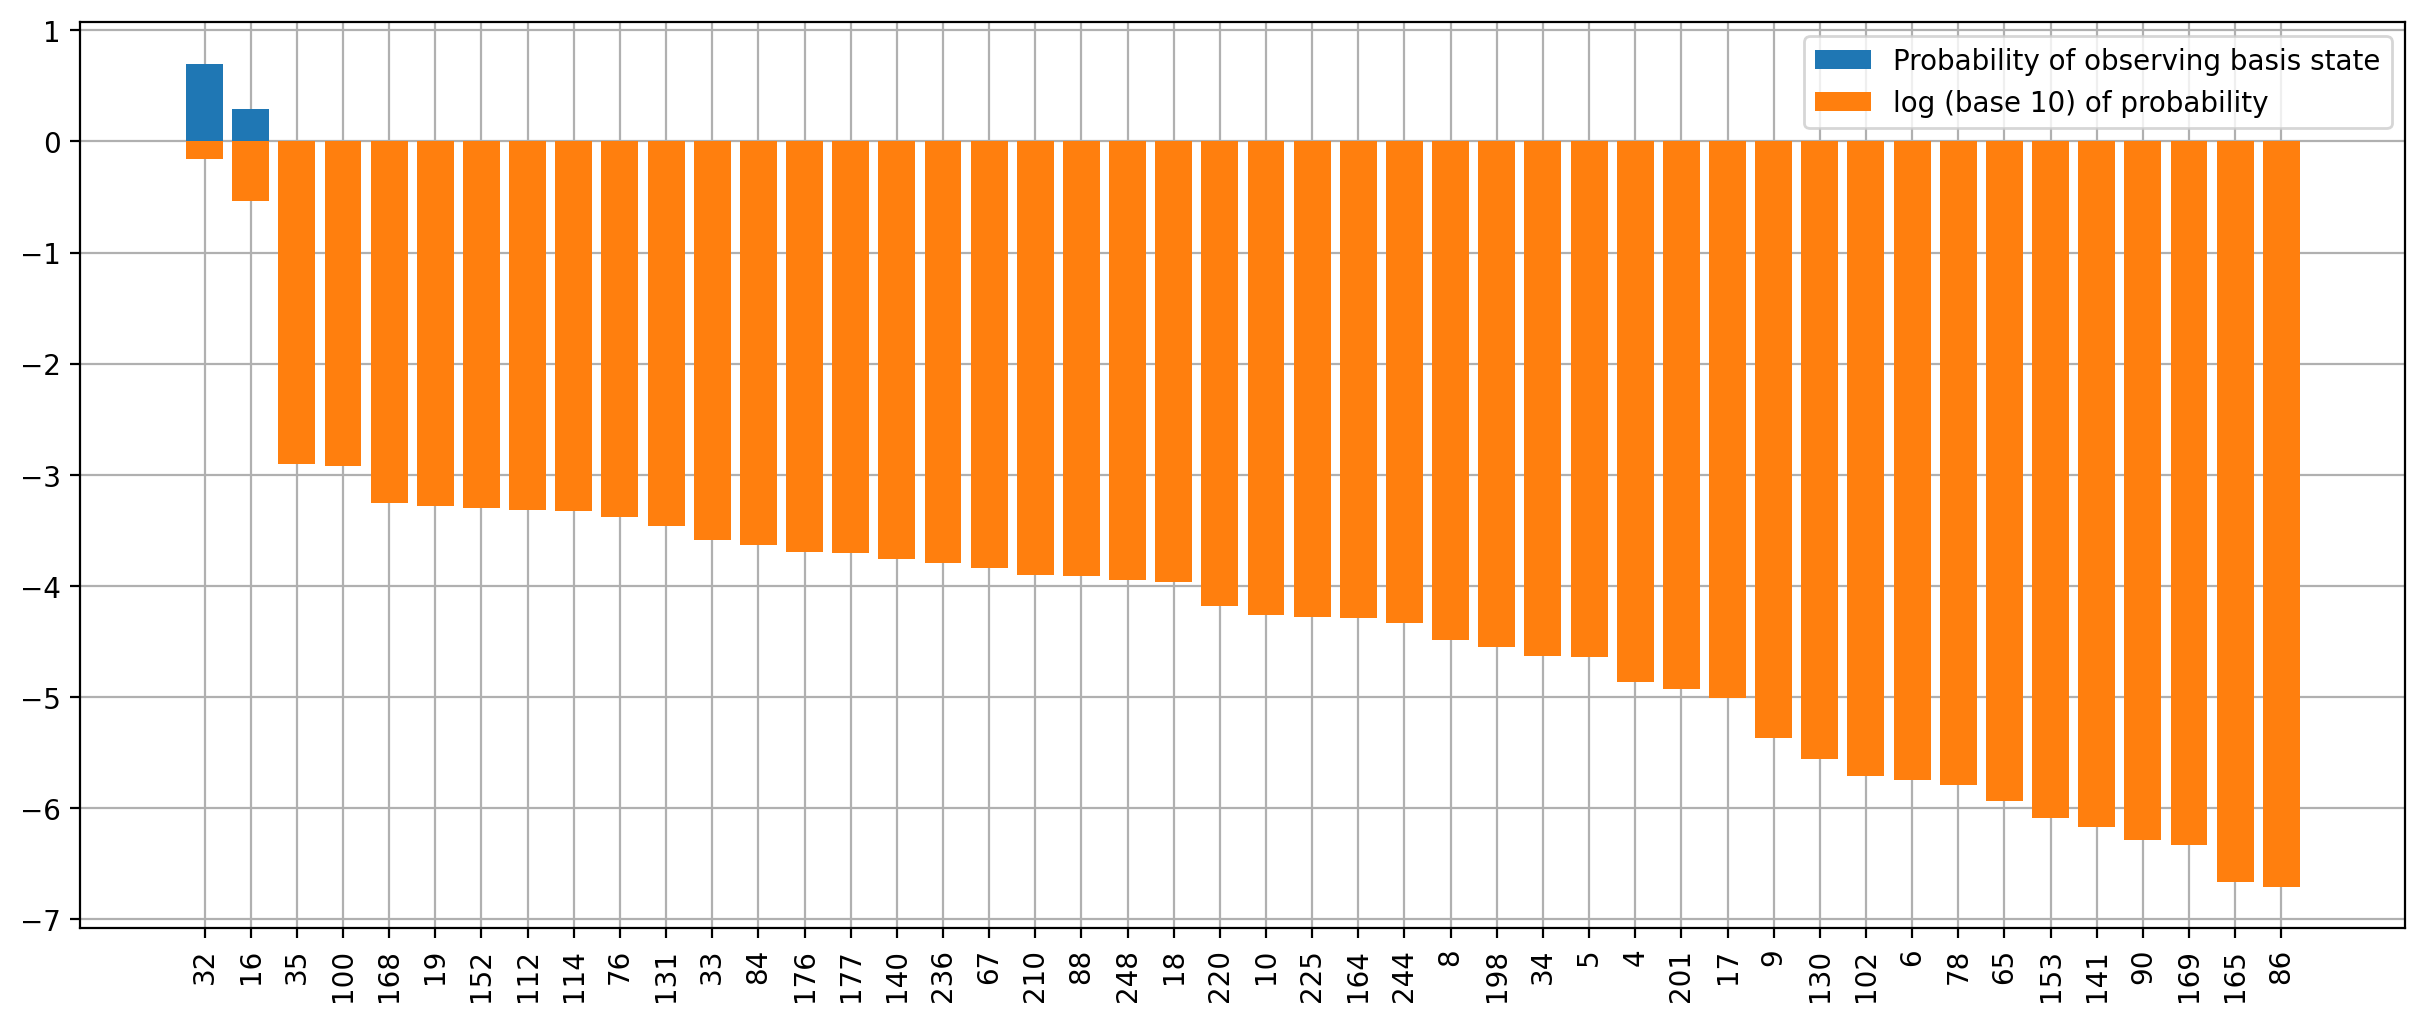

In [174]:
gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())
true_gs = gs[0]

amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = sorted([(str(index), a) for index, a in enumerate(amp_list) if a > 10**-7], key=lambda x:x[1])
sig_amp_list.reverse()

XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]
Y_log = [np.log10(a) for a in Y]

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=200)

plt.grid(zorder=0)
plt.bar(X, Y, zorder=2, label='Probability of observing basis state')
plt.bar(X, Y_log, zorder=3, label = 'log (base 10) of probability')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [206]:
eig.int_to_bin(100, num_qubits)

'01100100'

[] []


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


['ZIIIIIII'] [0]
['IZIIIIII', 'ZIIIIIII'] [1, 0]
['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [2, 1, 0]
['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 2, 1, 0]
['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 3, 2, 1, 0]
['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 4, 3, 2, 1, 0]
['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [7, 5, 4, 3, 2, 1, 0]


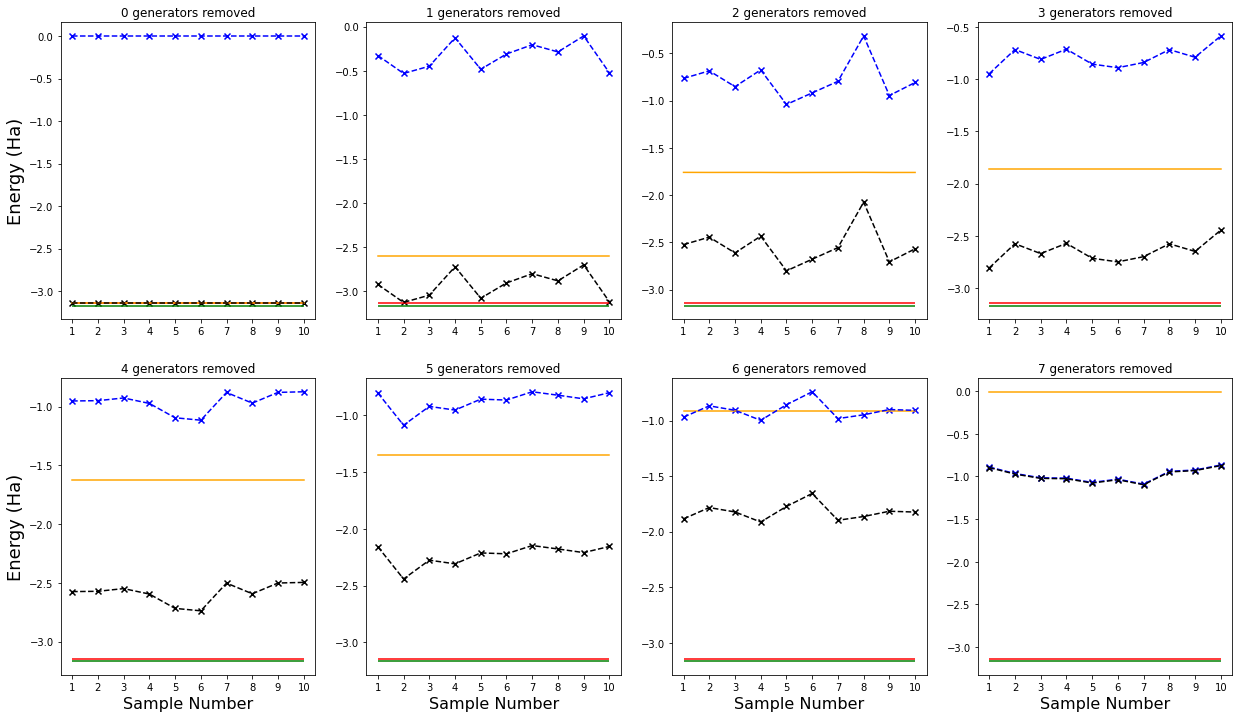

In [276]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10
#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
molecule='HeH+'

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
#grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context, num_qubits)

    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = eig.random_vector(2**len(removed_index))
        rand_vec = sorted([eig.random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)
        
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                                  r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
                                                                  Z_indices=Z_indices,rot=True)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

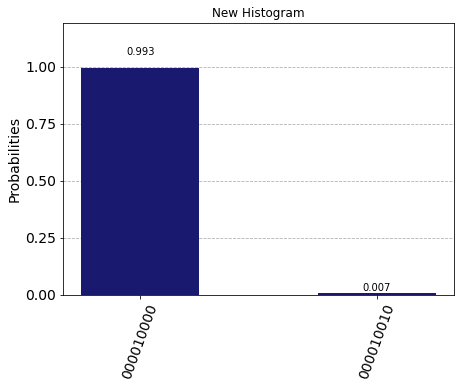

In [255]:
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.algorithms import VQE
from qiskit import Aer

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits+1)

anz.x(4)

#store parity in auxiliary qubit (8) via CNOT cascade
anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
#move into +1-eigenstate
anz.cry(2*t2+0.2, 8, 1)
anz.x(8)
anz.cry(2*t2+0.2, 8, 1)
anz.x(8)
#reverse CNOT cascade
anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
anz.x(1)

anz.measure_all()
#print(anz.draw())
backend = BasicAer.get_backend('qasm_simulator')
job = execute(anz, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

In [418]:
removed_generators = ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII','IIIZIIII','IIIIZIII','IIIIIZII', 'IIIIIIIZ']
new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

slsqp = SLSQP(maxiter=100)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits)

anz.x(4)
anz.rx(Parameter('a'), 7)
anz.rx(Parameter('b'), 6)
anz.rx(Parameter('c'), 5)
anz.rx(Parameter('d'), 4)
anz.rx(Parameter('e'), 3)
anz.rx(Parameter('f'), 2)
anz.rx(Parameter('g'), 0)
#anz.rx(Parameter('b'), 5)

#store parity in auxiliary qubit (8) via CNOT cascade
anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 0)
#move into +1-eigenstate
anz.cry(2*t1, 0, 1)
anz.x(0)
anz.cry(2*t2, 0, 1)
anz.x(0)
#reverse CNOT cascade
anz.cx(6, 0),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
anz.x(1)

vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

# run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
X_noncon = deepcopy(counts)
Y_noncon = deepcopy(values)
counts.clear(), values.clear()

# run VQE on contextual hamiltonian
vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
X_context = deepcopy(counts)
Y_context = deepcopy(values)

vqe_result_noncon = vqe_run_noncon.optimal_value
vqe_result_context = vqe_run_context.optimal_value
vqe_result = vqe_result_noncon + vqe_result_context

print('VQE:', vqe_result_noncon,'+', vqe_result_context,'=', vqe_result, '|', 'Improves noncontextual estimate?', vqe_result<gs_noncon_energy)

VQE: -0.006852716593805389 + -3.1359720043720603 = -3.1428247209658657 | Improves noncontextual estimate? False


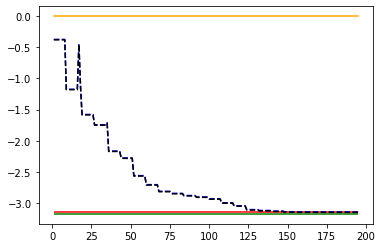

In [419]:
X=X_context
conv_diff = len(X_context) - len(X_noncon)

if conv_diff < 0:
    Y_noncon = Y_noncon[0:len(X)]
else:
    for i in range(conv_diff):
        Y_noncon.append(Y_noncon[-1])

Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]

plt.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
plt.plot(X, Y_context, color='blue', ls='--')
#plt.scatter(X, Y_total, color='black', marker = 'x')
plt.plot(X, Y_total, color='black', ls='--')

plt.hlines(gs_noncon_energy, 1, len(X), color='r')
plt.hlines(true_gs, 1, len(X), color='g')

In [461]:
ucc_fix_q1 = []
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
for p in ucc.keys():
    p_list = list(p)
    p_list[6] = 'I'
    #p_list.reverse()
    ucc_fix_q1.append(''.join(p_list))
print(ucc_fix_q1)

['YZXIIIII', 'XZYIIIII', 'YYYXIIII', 'YXYYIIII', 'XXYXIIII', 'XYYYIIII', 'YXXXIIII', 'YYXYIIII', 'XYXXIIII', 'XXXYIIII', 'IYZXIIII', 'IXZYIIII', 'YZZZXIII', 'XZZZYIII', 'YYIIYXII', 'YXIIYYII', 'XXIIYXII', 'XYIIYYII', 'YXIIXXII', 'YYIIXYII', 'XYIIXXII', 'XXIIXYII', 'IYZZZXII', 'IXZZZYII', 'YZZZZZII', 'XZZZZZII', 'YYIIIIIX', 'YXIIIIIY', 'XXIIIIIX', 'XYIIIIIY', 'YXIIIIIX', 'YYIIIIIY', 'XYIIIIIX', 'XXIIIIIY', 'IYZZZZIX', 'IXZZZZIY']


[] []
['ZIIIIIII'] [7]
***Winner*** -3.1441216329442434
***Winner*** -3.144121632555154
***Winner*** -3.1441216325551524
***Winner*** -3.1441216318962866
***Winner*** -3.1441216318115948
***Winner*** -3.1441216332879227
***Winner*** -3.144121632151854
***Winner*** -3.144121633709776
***Winner*** -3.1441216320965193
***Winner*** -3.1441216337944025
***Winner*** -3.1441216341270355
***Winner*** -3.144121632239728
***Winner*** -3.1441216322120313
***Winner*** -3.1441216329264092
***Winner*** -3.144121632691891
***Winner*** -3.1441216384290844
***Winner*** -3.1441216379790218
***Winner*** -3.1441216281822673
***Winner*** -3.1441216389891933
***Winner*** -3.1441216383549113
***Winner*** -3.144121627322172
***Winner*** -3.144121637823522
***Winner*** -3.1441216383497252
***Winner*** -3.1441216333336435
***Winner*** -3.1441216333198962
***Winner*** -3.144121631525558
***Winner*** -3.1441216312353535
***Winner*** -3.1478453798576056
***Winner*** -3.147845380344796
***Winner*** -3.1478453809731

***Winner*** -3.433785850484234
***Winner*** -3.4337858504842345
***Winner*** -3.4337858506002
***Winner*** -3.4337858505305747
***Winner*** -3.4337858501843246
***Winner*** -3.4337858501839893
***Winner*** -3.4337858501988876
***Winner*** -3.433785850931032
***Winner*** -3.4337858509318773
***Winner*** -3.433785850199767
***Winner*** -3.433785850184684
***Winner*** -3.433785850183604
***Winner*** -3.4337858507894605
***Winner*** -3.433785850786184
***Winner*** -3.4337858503517755
***Winner*** -3.4337858505496826
***Winner*** -3.433785850259409
***Winner*** -3.4337858502489955
***Winner*** -3.43378585042485
***Winner*** -3.4337858506976935
***Winner*** -3.433785850957055
***Winner*** -3.433785850184172
***Winner*** -3.4337858502794254
***Winner*** -3.4337858502800187
***Winner*** -3.4337858501319642
***Winner*** -3.433785850133607
***Winner*** -3.4358042865394958
***Winner*** -3.435804286407863
***Winner*** -3.435804286407864
***Winner*** -3.4358042870364702
***Winner*** -3.43580428703

***Winner*** -3.4566051212944826
***Winner*** -3.45660512107477
***Winner*** -3.456605120927183
***Winner*** -3.456605121573843
***Winner*** -3.4566051212692392
***Winner*** -3.4566051212011133
***Winner*** -3.456605120985778
***Winner*** -3.456605121076355
***Winner*** -3.4572241417258445
***Winner*** -3.457224141691098
***Winner*** -3.4572241416910994
***Winner*** -3.457224141751649
***Winner*** -3.4572241417516496
***Winner*** -3.4572241417481884
***Winner*** -3.4572241417034983
***Winner*** -3.4572241417481897
***Winner*** -3.4572241417034975
***Winner*** -3.4572241417000393
***Winner*** -3.4572241417000393
***Winner*** -3.4572241416881813
***Winner*** -3.457224141688182
***Winner*** -3.457224141805903
***Winner*** -3.457224141645825
***Winner*** -3.4572241415217135
***Winner*** -3.457224141520839
***Winner*** -3.457224141536375
***Winner*** -3.4572241419141534
***Winner*** -3.457224141915516
***Winner*** -3.457224141537202
***Winner*** -3.4572241415220253
***Winner*** -3.457224141

***Winner*** -3.463816069157064
***Winner*** -3.4638160691613677
***Winner*** -3.4638160691570645
***Winner*** -3.463816069150875
***Winner*** -3.463816069150874
***Winner*** -3.4638160691543485
***Winner*** -3.4638160691543494
***Winner*** -3.4638160691483995
***Winner*** -3.4638160691700324
***Winner*** -3.4638160692022333
***Winner*** -3.463816069202437
***Winner*** -3.463816069203304
***Winner*** -3.463816069115453
***Winner*** -3.463816069115122
***Winner*** -3.4638160692029905
***Winner*** -3.4638160692022217
***Winner*** -3.4638160692024282
***Winner*** -3.4638160690856328
***Winner*** -3.4638160690617616
***Winner*** -3.463816069176918
***Winner*** -3.4638160692062163
***Winner*** -3.4638160691746007
***Winner*** -3.4638160691514797
***Winner*** -3.4638160691750683
***Winner*** -3.463816069144027
***Winner*** -3.463816069185785
***Winner*** -3.4638160691255107
***Winner*** -3.463816069257689
***Winner*** -3.4638160691817115
***Winner*** -3.463816069192106
***Winner*** -3.463816

['IZIIIIII', 'ZIIIIIII'] [6, 7]
['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 6, 7]
['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 5, 6, 7]
['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 4, 5, 6, 7]
***Winner*** -3.1429184709602445
***Winner*** -3.1429184709775413
***Winner*** -3.142918470945195
***Winner*** -3.1429184710299176
***Winner*** -3.1429184709099256
***Winner*** -3.142918470932858
***Winner*** -3.1429184709399074
***Winner*** -3.14291847098037
***Winner*** -3.1429184709876434
***Winner*** -3.1429184709655007
***Winner*** -3.142918470960006
***Winner*** -3.1429184709313
***Winner*** -3.1429184709267988
***Winner*** -3.142987464772836
***Winner*** -3.1429874648547536
***Winner*** -3.1429874648165153
***Winner*** -3.142987464911303
***Winner*** -3.142987464899708
***Winner*** -3.1429874648863354
***Winner*** -3.1429874647587637
***Winner*** -3.142987464862949
***Winner*** -3.1429874647467626
***Winner*** -3.1429874647100107
***Winner*** -3.1429874647296767
**

['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [2, 3, 4, 5, 6, 7]
***Winner*** -3.1838450976174077
***Winner*** -3.1838451000595653
***Winner*** -3.183845100129858
***Winner*** -3.18384509714764
***Winner*** -3.1838450972179357
***Winner*** -3.183845099530944
***Winner*** -3.1838450958299993
***Winner*** -3.1838450994317586
***Winner*** -3.1838450957308124
***Winner*** -3.1838450984631814
***Winner*** -3.1838450984631526
***Winner*** -3.1838450950613666
***Winner*** -3.1838450947755916
***Winner*** -3.1838450982783177
***Winner*** -3.1838450968606367
***Winner*** -3.183845101376066
***Winner*** -3.1838451014158142
***Winner*** -3.183845100339127
***Winner*** -3.1838450949745614
***Winner*** -3.183845095103134
***Winner*** -3.183845100178346
***Winner*** -3.1838451014169245
***Winner*** -3.1838451015316425
***Winner*** -3.183845099058469
***Winner*** -3.183845098505338
***Winner*** -3.183845098398598
***Winner*** -3.183845097671215
***Winner*** -3.1838450965724

***Winner*** -3.346354278947316
***Winner*** -3.3463542789458
***Winner*** -3.346354278947318
***Winner*** -3.3463542789457983
***Winner*** -3.3463542789498573
***Winner*** -3.3463542789498573
***Winner*** -3.3463542789429117
***Winner*** -3.3463542789429113
***Winner*** -3.3463542789529623
***Winner*** -3.3463542789401517
***Winner*** -3.3463542789559737
***Winner*** -3.3463542789558303
***Winner*** -3.3463542789388536
***Winner*** -3.346354278954203
***Winner*** -3.3463542789542617
***Winner*** -3.34635427893891
***Winner*** -3.3463542789559693
***Winner*** -3.3463542789558254
***Winner*** -3.346354278951981
***Winner*** -3.346354278952432
***Winner*** -3.3463542789697813
***Winner*** -3.346354278946735
***Winner*** -3.346354278940536
***Winner*** -3.346354278948838
***Winner*** -3.3463542789613174
***Winner*** -3.346354278935095
***Winner*** -3.3463542789583656
***Winner*** -3.3463542789222696
***Winner*** -3.346354278953466
***Winner*** -3.3463542789658707
***Winner*** -3.346354278

***Winner*** -3.273689067378654
***Winner*** -3.273689067357782
***Winner*** -3.2739000461930092
***Winner*** -3.2739000462591497
***Winner*** -3.2739000462591523
***Winner*** -3.2739000462688184
***Winner*** -3.2739000462688184
***Winner*** -3.273900046065893
***Winner*** -3.273900046320131
***Winner*** -3.273900046065896
***Winner*** -3.273900046320127
***Winner*** -3.273900046117206
***Winner*** -3.273900046117206
***Winner*** -3.273900046305317
***Winner*** -3.2739000463053203
***Winner*** -3.2739000461618297
***Winner*** -3.2739000461639955
***Winner*** -3.2739000461209926
***Winner*** -3.273900046121364
***Winner*** -3.273900046265765
***Winner*** -3.2739000461198815
***Winner*** -3.273900046248396
***Winner*** -3.2739000461379266
***Winner*** -3.273900046246983
***Winner*** -3.273900046247294
***Winner*** -3.2739000461952394
***Winner*** -3.273900046195074
***Winner*** -3.273900046155893
***Winner*** -3.273900046172609
***Winner*** -3.273900046270469
***Winner*** -3.273900046217

***Winner*** -3.2758831324658706
***Winner*** -3.275883132358741
***Winner*** -3.2758831324516717
***Winner*** -3.275883132445449
***Winner*** -3.275883132414875
***Winner*** -3.275883132496094
***Winner*** -3.2758831323806508
***Winner*** -3.275883132520317
***Winner*** -3.2758831325630853
***Winner*** -3.275883132579144
***Winner*** -3.2758831324700353
***Winner*** -3.275883132524131
***Winner*** -3.276100352018669
***Winner*** -3.276100351943308
***Winner*** -3.2761003519432976
***Winner*** -3.2761003521461807
***Winner*** -3.276100352146182
***Winner*** -3.2761003518708898
***Winner*** -3.2761003521664422
***Winner*** -3.276100351870891
***Winner*** -3.2761003521664387
***Winner*** -3.2761003518911527
***Winner*** -3.2761003518911527
***Winner*** -3.2761003521371452
***Winner*** -3.276100352137142
***Winner*** -3.2761003521093466
***Winner*** -3.2761003519323113
***Winner*** -3.276100351970106
***Winner*** -3.276100351989386
***Winner*** -3.2761003520474943
***Winner*** -3.27610035

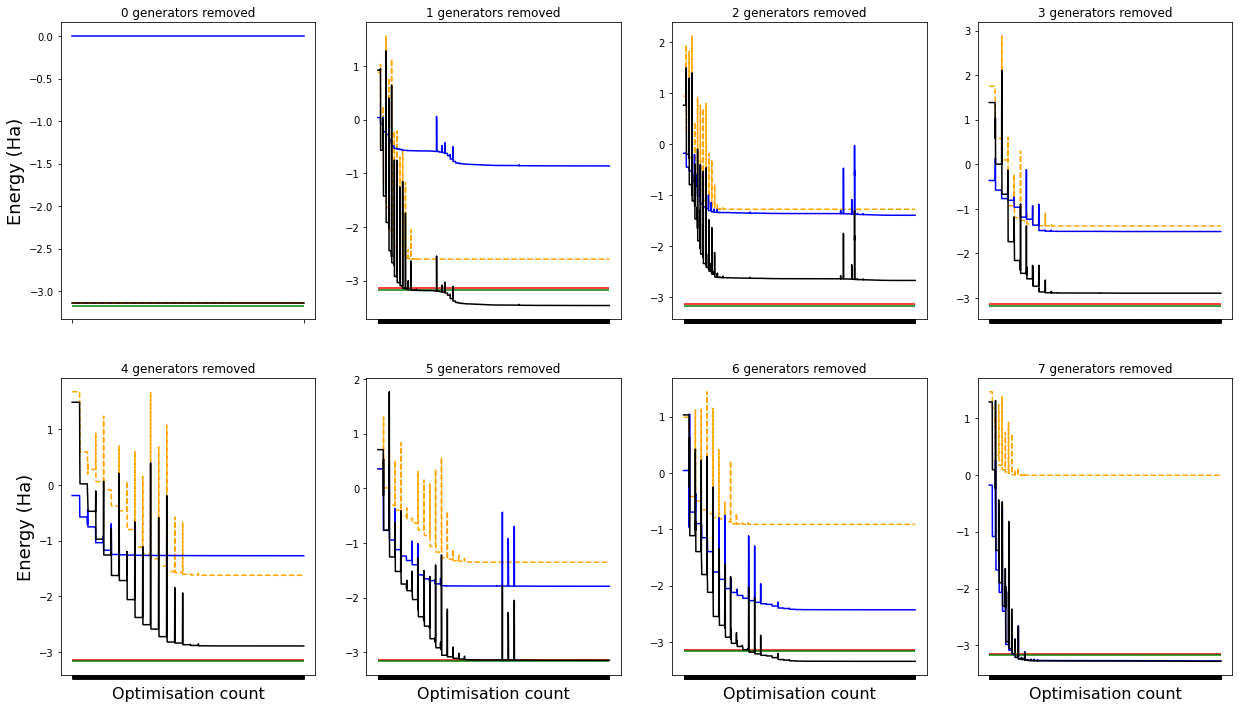

In [462]:
#VQE setup
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
slsqp = SLSQP(maxiter=1000)
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# create blank plot
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]

# compute +1-eigenspace quotient
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

# create blank parameters to assign in circuit for VQE optimsisation
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']
params = [] 
for comb in list(itertools.combinations(param_chars, 2)):
    char_str = ''.join(comb)
    params.append(Parameter(char_str))

#discard generators left to right whilst performing VQE
for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [7 - g.find('Z') for g in removed_generators]
    
    print(removed_generators, Z_indices)

    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
    vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context)
    
    # initiate blank circuit
    anz=QuantumCircuit(num_qubits)
    
    # noncontextual reference
    anz.x(4)
    
    # search over space not fixed by generators
    if Z_indices == []:
        anz.rz(params[0], 4) # because VQE needs at least one parameter...
    else:
        #for index, z in enumerate(Z_indices):
        #    anz.rx(params[index], z)
        anz = c_anz.construct_ansatz(paulis=ucc_fix_q1, circ=anz)
    
    # store parity in auxiliary qubit (8) via CNOT cascade
    anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 0)
    # move into +1-eigenspace
    anz.cry(2*t1, 0, 1)
    anz.x(0)
    anz.cry(2*t2, 0, 1)
    anz.x(0)
    # reverse CNOT cascade
    anz.cx(6, 0),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
    anz.x(1)
    
    # create VQE routine
    vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

    # run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
    vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
    X_noncon = deepcopy(counts)
    Y_noncon = deepcopy(values)
    counts.clear(), values.clear()

    # run VQE on contextual hamiltonian
    vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
    X_context = deepcopy(counts)
    Y_context = deepcopy(values)
    counts.clear(), values.clear()
    
    # increase or decrease size of Y_noncon to match Y_context
    X=X_context
    conv_diff = len(X_context) - len(X_noncon)
    if conv_diff < 0:
        Y_noncon = Y_noncon[0:len(X)]
    else:
        for i in range(conv_diff):
            Y_noncon.append(Y_noncon[-1])
    
    # combined approximation
    Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]
    for i in Y_total:
        if i < gs_noncon_energy:
            print('***Winner***', i)
            
    # plot results in corresponding subfigure
    axs[grid].plot(X, Y_noncon, color='orange',ls='--')
    #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue')
    #axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_total, color='black')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, len(X), color='r')
    axs[grid].hlines(true_gs, 1, len(X), color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    axs[grid].set_xticklabels([])
    if grid[0] == 1:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [442]:
fig.savefig("plots/HeH+-generator-removal-energies-VQE-naive_ansatz.png", dpi=300)

In [182]:
for index, r in enumerate(rotations):
    rotations[index][0] = np.pi/4
print(rotations)

[[0.7853981633974483, 'YIIIIIII'], [0.7853981633974483, 'YIIIIIZI'], [0.7853981633974483, 'IYIIIIII'], [0.7853981633974483, 'IYIIIIIZ']]


In [129]:
help(eig.expectation)

Help on function expectation in module utils.eigenstate_generator:

expectation(op, state, num_qubits)



In [153]:
ucc_param={}
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
import itertools
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']
params = [] 
for comb in list(itertools.combinations(param_chars, 2)):
    char_str = ''.join(comb)
    params.append(Parameter(char_str))

for index, p in enumerate(ucc.keys()):
    ucc_param[p] = params[index]
    
qonvert.dict_to_QubitOperator(ucc_param, num_qubits)

In [156]:
qonvert.dict_to_QubitOperator(ucc_param, num_qubits)

ValueError: Coefficient must be a numeric type.

In [162]:
anz = c_anz.construct_ansatz(init_state=[0,1,2,3], paulis=list(ucc.keys()))

┌───┐ ░ ┌─────┐┌───┐                                 ┌───┐┌───┐ ░  ░ »
q_0: ┤ X ├─░─┤ SDG ├┤ H ├──■───────────────────────────■──┤ H ├┤ S ├─░──░─»
     ├───┤ ░ └─────┘└───┘┌─┴─┐                       ┌─┴─┐└───┘└───┘ ░  ░ »
q_1: ┤ X ├─░─────────────┤ X ├──■─────────────────■──┤ X ├───────────░──░─»
     ├───┤ ░  ┌───┐      └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤           ░  ░ »
q_2: ┤ X ├─░──┤ H ├───────────┤ X ├┤ RZ(2*αβγ) ├┤ X ├┤ H ├───────────░──░─»
     ├───┤ ░  └───┘           └───┘└───────────┘└───┘└───┘           ░  ░ »
q_3: ┤ X ├─░─────────────────────────────────────────────────────────░──░─»
     └───┘ ░                                                         ░  ░ »
q_4: ──────░─────────────────────────────────────────────────────────░──░─»
           ░                                                         ░  ░ »
q_5: ──────░─────────────────────────────────────────────────────────░──░─»
           ░                                                         ░  ░ »
q_6: ──────░─────────────────────────────────────────────────────────░──░─»
           ░                                                         ░  ░ »
q_7: ──────░─────────────────────────────────────────────────────────░──░─»
           ░                                                         ░  ░ »
«      ┌───┐                                  ┌───┐ ░  ░ ┌─────┐┌───┐          »
«q_0: ─┤ H ├───■───────────────────────────■──┤ H ├─░──░─┤ SDG ├┤ H ├──■───────»
«      └───┘ ┌─┴─┐                       ┌─┴─┐└───┘ ░  ░ ├─────┤├───┤┌─┴─┐     »
«q_1: ───────┤ X ├──■─────────────────■──┤ X ├──────░──░─┤ SDG ├┤ H ├┤ X ├──■──»
«     ┌─────┐├───┤┌─┴─┐┌───────────┐┌─┴─┐├───┤┌───┐ ░  ░ ├─────┤├───┤└───┘┌─┴─┐»
«q_2: ┤ SDG ├┤ H ├┤ X ├┤ RZ(2*αβδ) ├┤ X ├┤ H ├┤ S ├─░──░─┤ SDG ├┤ H ├─────┤ X ├»
«     └─────┘└───┘└───┘└───────────┘└───┘└───┘└───┘ ░  ░ └┬───┬┘└───┘     └───┘»
«q_3: ──────────────────────────────────────────────░──░──┤ H ├────────────────»
«                                                   ░  ░  └───┘                »
«q_4: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«q_5: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«q_6: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«q_7: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«                                      ┌───┐┌───┐ ░  ░ ┌─────┐┌───┐          »
«q_0: ──────────────────────────────■──┤ H ├┤ S ├─░──░─┤ SDG ├┤ H ├──■───────»
«                                 ┌─┴─┐├───┤├───┤ ░  ░ └┬───┬┘└───┘┌─┴─┐     »
«q_1: ─────────────────────────■──┤ X ├┤ H ├┤ S ├─░──░──┤ H ├──────┤ X ├──■──»
«                            ┌─┴─┐├───┤├───┤└───┘ ░  ░ ┌┴───┴┐┌───┐└───┘┌─┴─┐»
«q_2: ──■─────────────────■──┤ X ├┤ H ├┤ S ├──────░──░─┤ SDG ├┤ H ├─────┤ X ├»
«     ┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘└───┘      ░  ░ ├─────┤├───┤     └───┘»
«q_3: ┤ X ├┤ RZ(2*αβε) ├┤ X ├┤ H ├────────────────░──░─┤ SDG ├┤ H ├──────────»
«     └───┘└───────────┘└───┘└───┘                ░  ░ └─────┘└───┘          »
«q_4: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »
«q_5: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »
«q_6: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »
«q_7: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                  

{'YZXIIIIZ': (-0-0.006360390047729467j),
 'XZYIIIZZ': -0.006360390047729467j,
 'YYYXIIII': -0.006478936130102838j,
 'YXYYIIIZ': (-0-0.006478936130102838j),
 'XXYXIIZZ': 0.006478936130102838j,
 'XYYYIIZI': (-0-0.006478936130102838j),
 'YXXXIIIZ': 0.006478936130102838j,
 'YYXYIIII': -0.006478936130102838j,
 'XYXXIIZI': 0.006478936130102838j,
 'XXXYIIZZ': 0.006478936130102838j,
 'IYZXIIII': 0.006360390047729467j,
 'IXZYIIIZ': 0.006360390047729467j,
 'YZZZXIIZ': (-0-0.002645411873769119j),
 'XZZZYIZZ': -0.002645411873769119j,
 'YYIIYXII': -0.0020562744029710704j,
 'YXIIYYIZ': (-0-0.0020562744029710704j),
 'XXIIYXZZ': 0.0020562744029710704j,
 'XYIIYYZI': (-0-0.0020562744029710704j),
 'YXIIXXIZ': 0.0020562744029710704j,
 'YYIIXYII': -0.0020562744029710704j,
 'XYIIXXZI': 0.0020562744029710704j,
 'XXIIXYZZ': 0.0020562744029710704j,
 'IYZZZXII': 0.002645411873769119j,
 'IXZZZYIZ': 0.002645411873769119j,
 'IZZZZZYZ': 0.0009221551709274561j,
 'ZZZZZZYZ': 0.0009221551709274561j,
 'IIIIIIXY': 0.005

In [275]:
new_ham_noncon

{'IIIIIIII': (1.1324434021069383+0j),
 'IIZIIIII': (-0.24607368520020115+0j),
 'IIIZIIII': (-0.24607368520020115+0j),
 'IIIIZIII': (-0.6730850144698549+0j),
 'IIIIIZII': (-0.6730850144698549+0j),
 'IIIIIIZI': (-1.140216532490732+0j),
 'IIIIIIIZ': (-1.1402165324907323+0j),
 'IIZZZZXI': (-0.06584241123629236+0j),
 'IIZZIIII': (0.13657384315761337+0j),
 'IIZIZIII': (0.11407664418119384+0j),
 'IIZIIZII': (0.14063916899332457+0j),
 'IIZIIIZI': (0.10734715467055872+0j),
 'IIZIIIIZ': (0.12260512697395698+0j),
 'IIIZZIII': (0.14063916899332457+0j),
 'IIIZIZII': (0.11407664418119384+0j),
 'IIIZIIZI': (0.12260512697395698+0j),
 'IIIZIIIZ': (0.10734715467055872+0j),
 'IIIIZZII': (0.17095384888863852+0j),
 'IIIIZIZI': (0.1135629724359024+0j),
 'IIIIZIIZ': (0.12110935730381613+0j),
 'IIIIIZZI': (0.12110935730381613+0j),
 'IIIIIZIZ': (0.1135629724359024+0j),
 'IIIIIIZZ': (0.2319626093284832+0j)}